In [1]:
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from fittingtask import FittingTask
import os
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
from matplotlib.lines import Line2D
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
homedir = os.path.expanduser('~')
def normalized_cmap(val, low, high, cmap):
    cmap = plt.get_cmap(cmap)
    rang=high-low
    return cmap(int((val-low)*255/rang))
c = 2.99792e5 # km/s

### Test remove wcoef from fir params

#### H band

In [28]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_2M0036/SDCH*.spec_a0v.fits'))

fluxes = []
wls = []
for filename in filelist:
    hdu = fits.open(filename)
    flux = hdu[0].data
    wl = hdu[1].data

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    fluxes.append(flux)
    wls.append(wl)

dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)
obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
eobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
wfobs0 = 1./eobs0**2   # make noise spectrum
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

nobs = dims[0]
norders = 20
npix = dims[2]

In [25]:
resultdir = f"{homedir}/uoedrive/result/CIFIST"
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{resultdir}/IGRINS2_2M0036_H_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{resultdir}/IGRINS2_2M0036_H_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{resultdir}/IGRINS2_2M0036_H_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['lte017.5-5.0', 'lte019.0-5.5'])

In [26]:
chisq[model]

51987.55631380578
51389.48554705065
65537.71247849867
68500.12209777927
66038.15346010921
66045.70706052138
51157.52940334525
51097.73468439354
49924.052468633454
65834.1061134336
66217.87194796727


In [ ]:
telluricfile = f"{homedir}/uoedrive/data/telluric/transdata_0,5-14_mic_hires.fits"
atm0 = fits.getdata(telluricfile)

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte019.0-5.5')

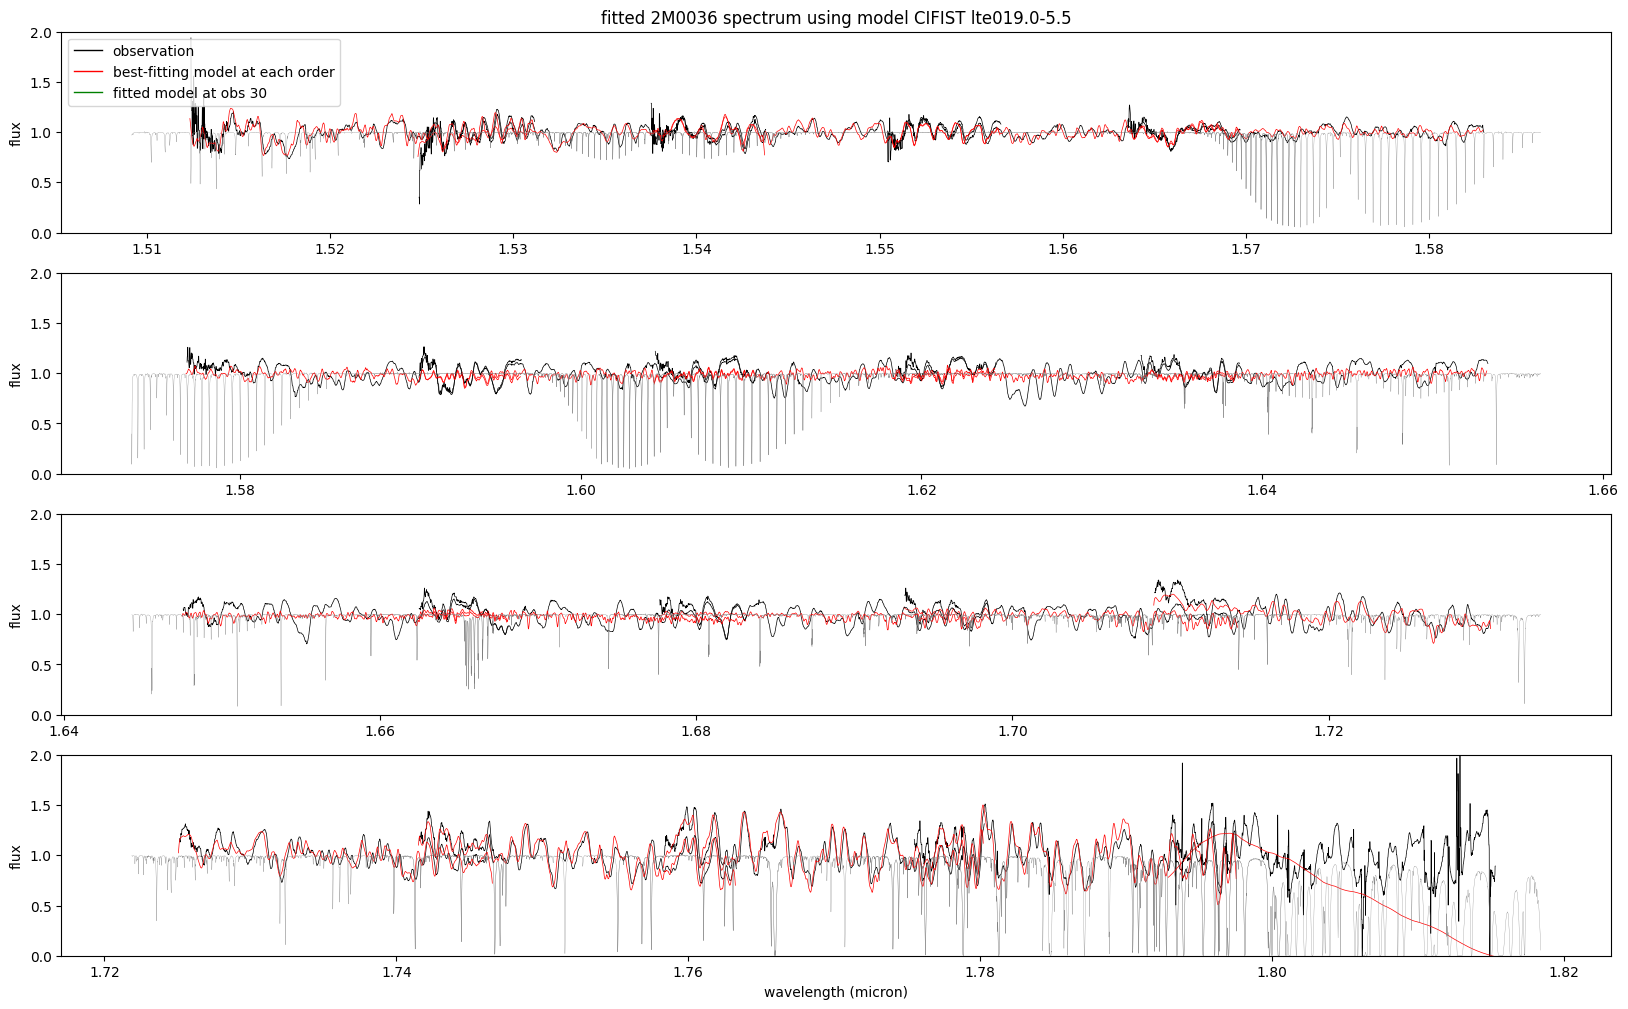

In [47]:
model = 'lte019.0-5.5'
obsn = 30
fobs = fobs0[:norders]
wobs = np.median(wls, axis=0)[:norders]
plt.figure(figsize=(20,12))
pix = np.arange(npix, dtype=float)/npix

start=15
end=-10
for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        lolim = wls[:, jj, :].min() - 0.003
        hilim = wls[:, jj, :].max() + 0.003
        aind = (atm0[:, 0]>lolim) * (atm0[:, 0] < hilim)
        lam_atmo = atm0[aind, 0]
        atmo = atm0[aind, 1]
        
        plt.plot(wobs[jj,start:end], fobs[jj,start:end], linewidth=0.5, color="black", label="observation")
        # plot best fitting obs of each order
        plt.plot(chiplams[model][obsn,jj,start:end], chipmods[model][obsn,jj,start:end], linewidth=0.5, color="r", label="fitted")
        # plot obs 21 of each order
        plt.plot(lam_atmo, atmo, linewidth=0.2, color="gray")
        #plt.plot(chiplams[model][obsn,jj], chipmods[model][obsn, jj], linewidth=0.5, color="g", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),
                        Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting model at each order", f"fitted model at obs {obsn}"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")

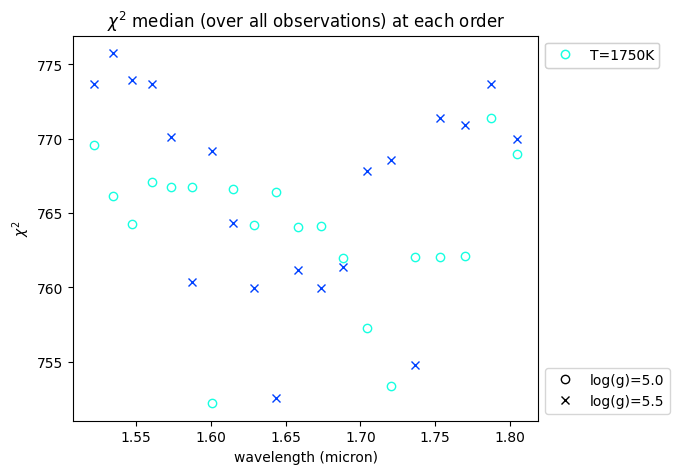

In [36]:
# chisq vs. order(wavelength), median over observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("$\chi^2$ median (over all observations) at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

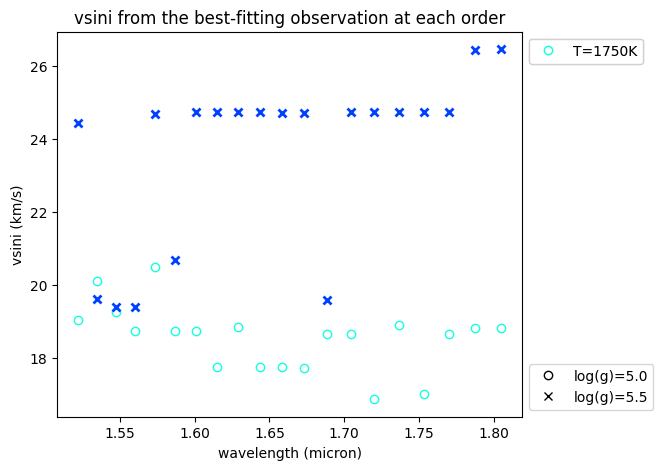

In [37]:
# fitted vsini vs. order(wavelength), best-fit obs
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    mfc = 'none'
    if "-5.0" in model:
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        vsini_points = vsini[model].reshape((nobs,norders))[obsn,:]
        plt.plot(lam_points, vsini_points, "o", mfc=mfc, color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        vsini_points = vsini[model].reshape((nobs,norders))[obsn,:]
        if "19.0" in model:
            plt.plot(lam_points, vsini_points, "x", mfc=mfc, color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'), markeredgewidth=2)
        else:
            plt.plot(lam_points, vsini_points, "x", mfc=mfc, color=normalized_cmap(temp,low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("vsini (km/s)")
    #plt.ylim((20,60))
    plt.title("vsini from the best-fitting observation at each order")
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

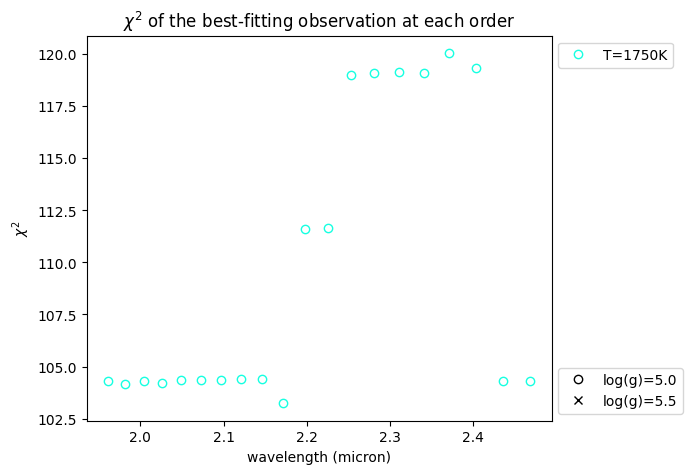

In [22]:
# chisq vs. order(wavelength), min of all observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.min(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.min(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    plt.title("$\chi^2$ of the best-fitting observation at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

#### K band

In [51]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_2M0036/SDCK*.spec_a0v.fits'))

fluxes = []
wls = []
for filename in filelist:
    hdu = fits.open(filename)
    flux = hdu[0].data
    wl = hdu[1].data

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    fluxes.append(flux)
    wls.append(wl)

dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)
obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
eobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)
wfobs0 = 1./eobs0**2   # make noise spectrum
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

nobs = dims[0]
norders = 20
npix = dims[2]

In [53]:
resultdir = f"{homedir}/uoedrive/result/CIFIST"
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{resultdir}/IGRINS2_2M0036_K_chipmods_*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{resultdir}/IGRINS2_2M0036_K_chiplams_*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{resultdir}/IGRINS2_2M0036_K_*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['lte017.5-5.0'])

In [66]:
fobs = fluxes[:, 1:norders, :]
fobs.shape

(42, 19, 1848)

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte017.5-5.0')

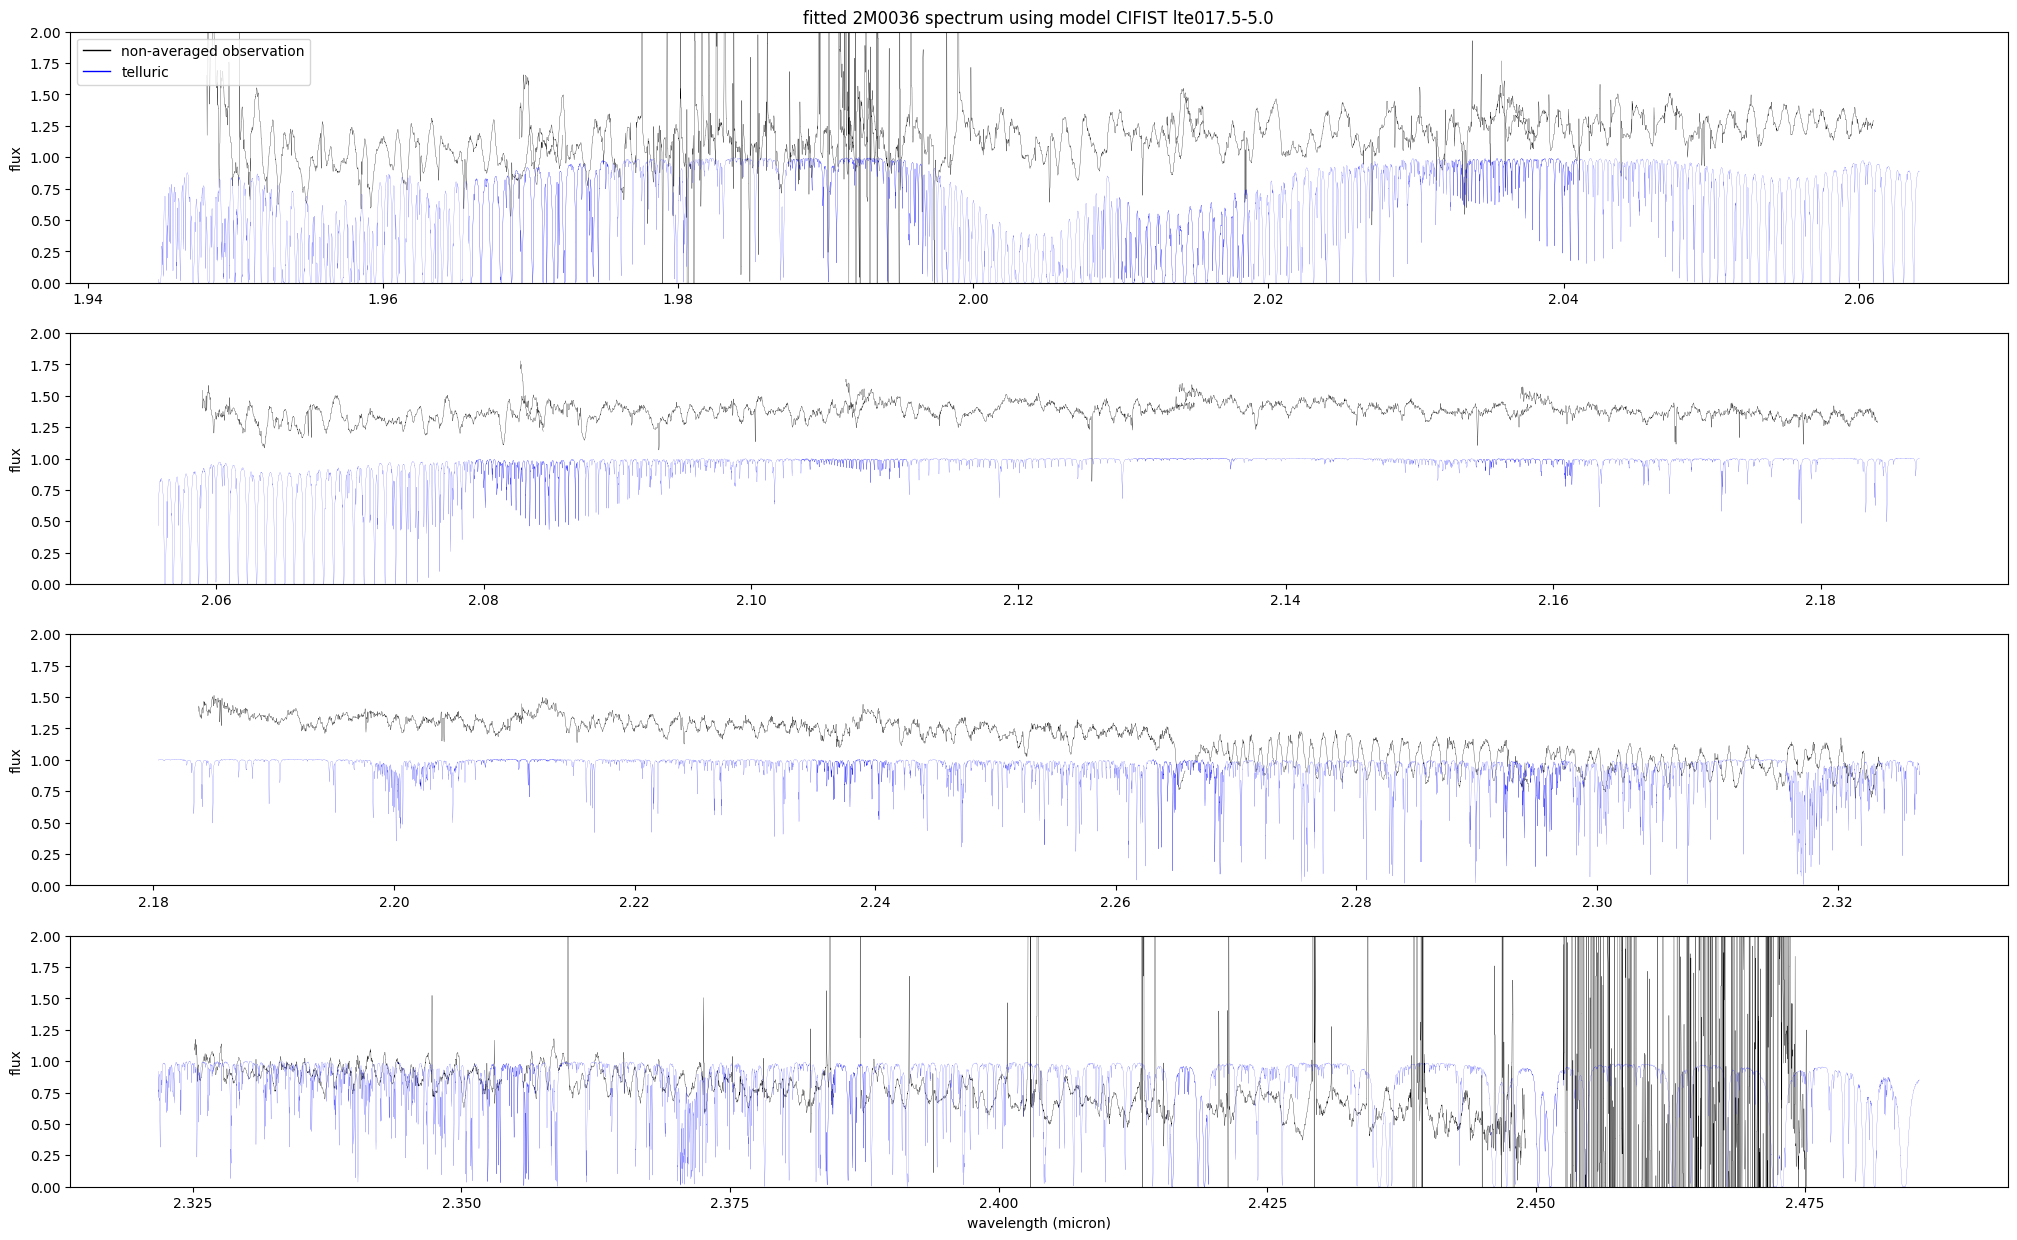

In [76]:
model = 'lte017.5-5.0'
obsn = 2
fobs = fobs0[:norders]
fobs = fluxes[0, :, :]
fobs = np.vstack([signal.medfilt(fobs[jj], 3) for jj in range(dims[1]-1)])
wobs = np.median(wls, axis=0)[:norders]
plt.figure(figsize=(25,15))
pix = np.arange(npix, dtype=float)/npix

start=15
end=-10
for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        lolim = wls[:, jj, :].min() - 0.003
        hilim = wls[:, jj, :].max() + 0.003
        aind = (atm0[:, 0]>lolim) * (atm0[:, 0] < hilim)
        lam_atmo = atm0[aind, 0]
        atmo = atm0[aind, 1]
        
        plt.plot(wobs[jj,start:end], fobs[jj,start:end], linewidth=0.2, color="black", label="observation")
        # plot best fitting obs of each order
        #plt.plot(chiplams[model][obsn,jj,start:end], chipmods[model][obsn,jj,start:end], linewidth=0.2, color="r", label="fitted")
        # plot obs 21 of each order
        plt.plot(lam_atmo, atmo, linewidth=0.1, color="blue")
        #plt.plot(chiplams[model][obsn,jj], chipmods[model][obsn, jj], linewidth=0.5, color="g", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="blue", lw=1),]
                        #Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["non-averaged observation", "telluric"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")

Use a single vsini for all orders.

In [113]:
obsn=22
model='lte017.5-5.0'
vsini_mean = vsini[model].reshape(nobs,norders).mean()
rv_this = rv[model].reshape(nobs,norders)[obsn]
lld_this = lld[model].reshape(nobs,norders)[obsn]
wcoef_this = wcoef[model].reshape(nobs,norders, 4)[obsn]
ccoef_this = ccoef[model].reshape(nobs,norders, 2)[obsn]

In [130]:
[vsini_mean, lld_this[jj], rv_this[jj]] + list(wcoef_this[jj]) + list(ccoef_this[jj])

[36.22165224084088,
 0.6067068010573264,
 -3.877285682244575e-05,
 9.265333899744776e-05,
 -0.003434487682186415,
 0.03046121691627564,
 2.157253677455534,
 -0.024243495282557384,
 1.0198482307941739]

In [136]:
results['wcoef'].reshape(42,20)[22]

array(['0.00013162748645013212, -0.0033750715132653403, 0.030366828699964044, 2.1572685374062908',
       '5.1123766687599466e-05, -0.0033469990917180574, 0.03041020420168476, 2.1572044063177884',
       '0.00016297612482906522, -0.0034850577396977975, 0.030446870502317952, 2.1572572490452995',
       '0.00012169087912380127, -0.0034615057972689394, 0.030460041079034963, 2.157247659976484',
       '0.0001297200555469492, -0.0034112073433438753, 0.030404503824377198, 2.1572653085895',
       '0.00014847026671403963, -0.00352689718885983, 0.030506654338430556, 2.1571980576650756',
       '8.884331511889654e-05, -0.0034003139093025316, 0.030428325165388632, 2.157266676695306',
       '0.00014040977319465755, -0.0035219147577627997, 0.03050723998543306, 2.157204012749263',
       '0.0001279347154141848, -0.0034825802556931592, 0.030476113346147634, 2.1572193763233023',
       '0.00013948159475946076, -0.0035052791000162262, 0.03048888452613291, 2.1571942020589345',
       '0.00014804748450

In [129]:
wcoef_this = [[float(j) for j in results['wcoef'].reshape(42,20)[22][jj].split(",")] for jj in range(20)]

In [137]:
import modelfitting as mf
chiplams_vsini = []
chipmods_vsini = []
for jj in range(norders):
    modelpath = f"{homedir}/uoedrive/data/BTSettlg5/lte017.5-5.0-0.0a+0.0.BT-Settl.spec.fits"
    model = Table.read(modelpath, format='fits')
    modelname = modelpath.split("/")[-1]
    model['wl'] = model['Wavelength']
    model['flux'] = model['Flux']
    lolim = wls[:, jj, :].min() - 0.003
    hilim = wls[:, jj, :].max() + 0.003
    tind = (model['wl']>lolim) * (model['wl'] < hilim)
    lam_template = model['wl'][tind]
    template = model['flux'][tind]
    template /= np.median(template)
    NPC=2
    NPW=4
    
    mymod, myw = mf.modelspec_template(
        [vsini_mean, lld_this[jj], rv_this[jj]] + list(wcoef_this[jj]) + list(ccoef_this[jj]),
        lam_template,
        template,
        NPW,
        NPC,
        npix,
        retlam=True)
    chiplams_vsini.append(myw)
    chipmods_vsini.append(mymod)

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte017.5-5.0')

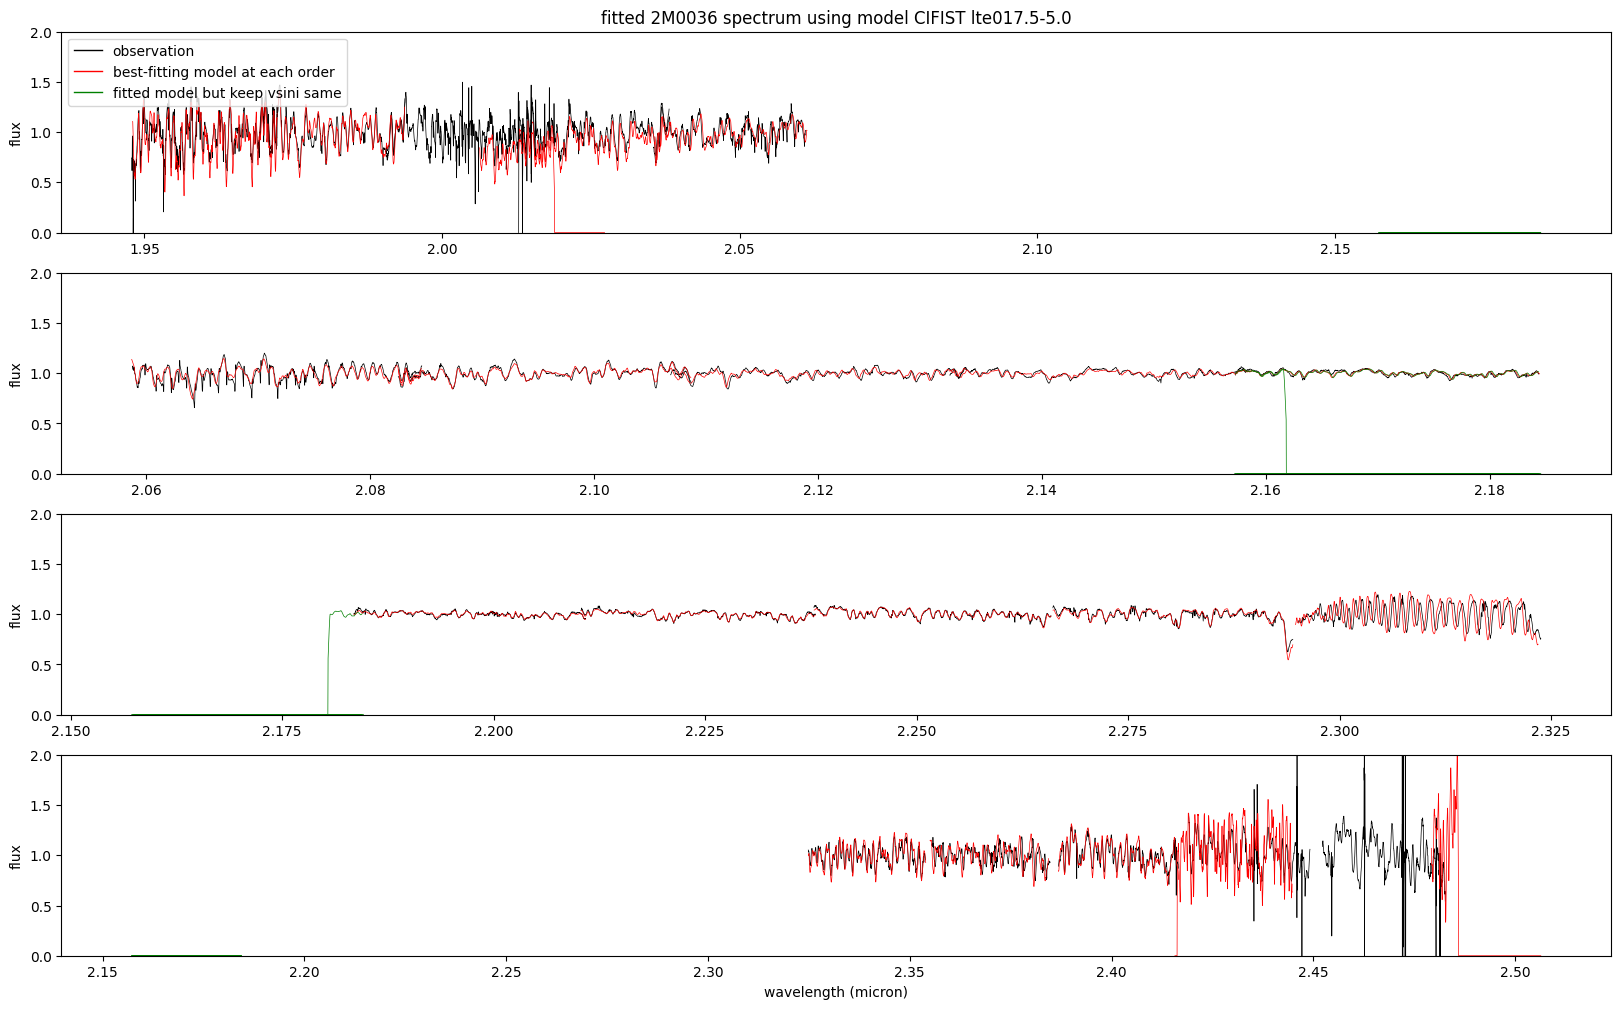

In [138]:
model = 'lte017.5-5.0'
obs = best_ind[model]
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
plt.figure(figsize=(20,12))
wcoef_this = wcoef[model].reshape((nobs, norders,4))[21]
pix = np.arange(npix, dtype=float)/npix

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs[jj,:], fobs[jj,:], linewidth=0.5, color="black", label="observation")
        # plot best fitting obs of each order
        plt.plot(chiplams[model][obs[:,jj], jj,:].flatten(), chipmods[model][obs[:,jj], jj,:].flatten(), linewidth=0.5, color="r", label="fitted")
        # plot chimods if vsini keep same
        plt.plot(chiplams_vsini[jj], chipmods_vsini[jj], linewidth=0.5, color="g", label="fitted")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="black", lw=1),
                        Line2D([0], [0], color="r", lw=1),
                        Line2D([0], [0], color="g", lw=1),]
        plt.legend(custom_lines, ["observation", "best-fitting model at each order", f"fitted model but keep vsini same"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")

### Non-stack

#### Load observed data for comparison

In [25]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_2M0036/SDCK*.spec_a0v.fits'))

fluxes = []
wls = []
for filename in filelist:
    hdu = fits.open(filename)
    flux = hdu[0].data
    wl = hdu[1].data

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]

    fluxes.append(flux)
    wls.append(wl)

dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

# remove first order with all NaNs when making various arrays
obs0 = fluxes[:, 1:, :]*dims[0]
eobs0 = fluxes[:, 1:, :]*np.sqrt(dims[0])  # make noise spectrum (assuming just photon noise)
fobs0 = np.array([[signal.medfilt(obs0[obs,jj], 3) for jj in range(dims[1]-1)] for obs in range(dims[0])])
fobs0 /= np.array([np.nanmedian(fobs0[obs], axis=1) for obs in range(dims[0])]).reshape(dims[0], dims[1]-1, 1)
eobs0 /= np.array([np.nanmedian(fobs0[obs], axis=1) for obs in range(dims[0])]).reshape(dims[0], dims[1]-1, 1)
wfobs0 = 1./eobs0**2   # make noise spectrum
wind = np.isinf(wfobs0)  # remove points with infinite values
wfobs0[wind] = 0.

# fix wavelength array to have same shape
wls = wls[:, 1:24, :]

#### Load K band results

In [7]:
resultdir = f"{homedir}/uoedrive/result/CIFIST"
chipmods = {}
chiplams = {}
chisq = {}
vsini = {}
rv = {}
lld = {}
modellist = []
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_nonstack_chipmods_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chipmods[modelname] = fits.getdata(f)
    modellist.append(modelname)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_nonstack_chiplams_*-5.*.fits")):
    modelname = f.split("_")[-1][:12]
    chiplams[modelname] = fits.getdata(f)
for f in sorted(glob.glob(f"{resultdir}/IGRINS_2M0036_K_nonstack_*-5.*.txt")):
    modelname = f.split("_")[-1][:12]
    results = Table.read(f, format='ascii')
    chisq[modelname] = results['chisq']
    vsini[modelname] = results['vsini']
    rv[modelname] = results['rv']
    lld[modelname] = results['lld']
chisq.keys()

dict_keys(['lte015.0-5.0'])

In [26]:
norders = 20
nobs = 42
obs = 0

In [45]:
# chisq vs. order(wavelength), median over observations
plt.figure(figsize=(6,5))
for model in modellist:
    temp = float(model[4:8])*100
    if "-5.0" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "o", mfc='none', color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'), label=f"T={temp:.0f}K")
    if "-5.5" in model:
        chisq_points = np.median(chisq[model].reshape((nobs, norders)), axis=0) # plot one point per wl
        lam_points = np.median(np.median(chiplams[model], axis=0), axis=1) # plot one point per wl
        plt.plot(lam_points, chisq_points, "x", mfc="none", color=normalized_cmap(temp, low=1250,high=2050,cmap='jet_r'))
    plt.xlabel("wavelength (micron)")
    plt.ylabel("$\chi^2$")
    #plt.ylim(10, 1e5)
    #plt.yscale("log")
    plt.title("$\chi^2$ median (over all observations) at each order") # plot one point per wl
    custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='none', color="black", lw=0),
                    Line2D([0], [0], marker='x', color="black", lw=0)]
    leg = plt.legend(loc=2, bbox_to_anchor=(1,1))
    plt.gca().add_artist(leg)
    plt.legend(custom_lines, ["log(g)=5.0", "log(g)=5.5"],loc=3, bbox_to_anchor=(1,0))

<Figure size 600x500 with 0 Axes>

In [97]:
lams_avg = chiplams[model][obs, :,:]

array([[2.47344192, 2.47346112, 2.47348031, ..., 2.50562189, 2.50563773,
        2.50565358],
       [2.41507373, 2.41509646, 2.41511918, ..., 2.44874984, 2.44876427,
        2.4487787 ],
       [2.38705359, 2.38707194, 2.38709028, ..., 2.41670583, 2.41671967,
        2.41673351],
       ...,
       [1.98781693, 1.98782984, 1.98784275, ..., 2.00846768, 2.00847722,
        2.00848675],
       [1.9687505 , 1.96876546, 1.96878042, ..., 1.99344671, 1.99345866,
        1.99347061],
       [1.9481356 , 1.94814992, 1.94816423, ..., 1.97233898, 1.97235085,
        1.97236272]])

Text(0.5, 1.0, 'fitted 2M0036 spectrum using model CIFIST lte015.0-5.0')

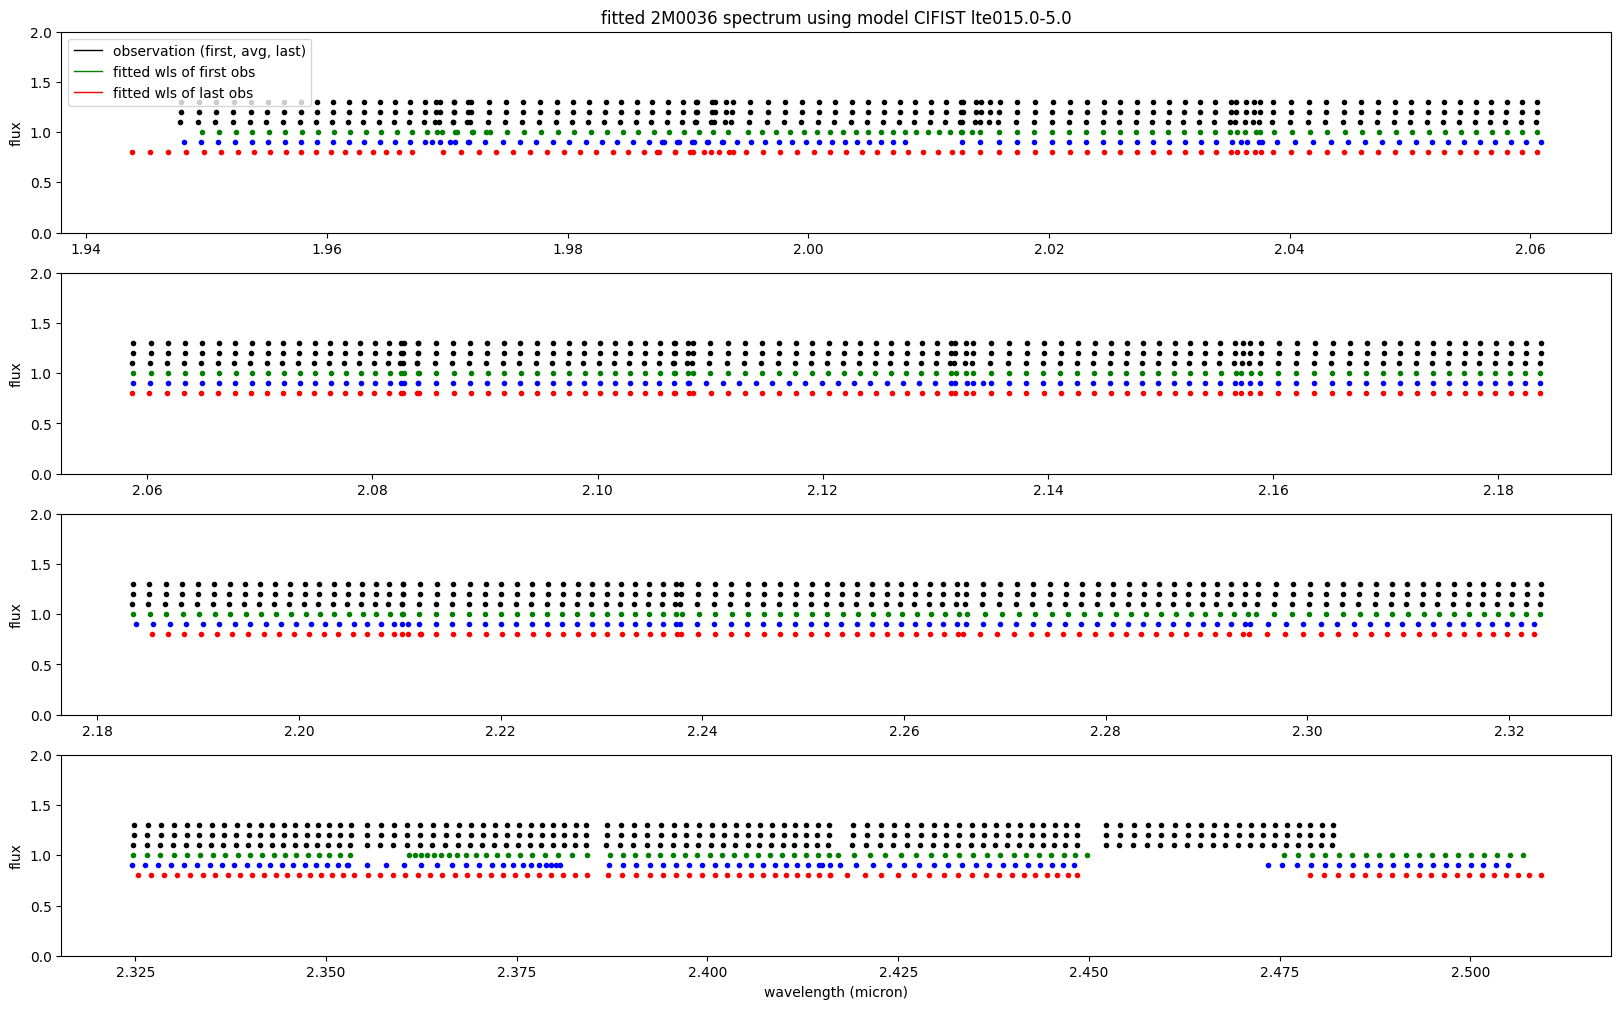

In [116]:
# plot the lambda points
model = 'lte015.0-5.0'
fobs = fobs0[:20]
wobs = np.median(wls, axis=0)[:20]
wobs_first = wls[0][:20]
wobs_last = wls[-1][:20]
plt.figure(figsize=(20,12))

for sub in range(4):
    plt.subplot(4,1, 4-sub)
    for jj in range(sub*5, sub*5+5):
        plt.plot(wobs_first[jj,::100], 1.3*np.ones(len(wobs_first[jj,::100])), ".", color="black", label="observation")
        plt.plot(wobs[jj,::100], 1.2*np.ones(len(wobs[jj,::100])), ".", color="black", label="observation")
        plt.plot(wobs_last[jj,::100], 1.1*np.ones(len(wobs_last[jj,::100])), ".", color="black", label="observation")
        plt.plot(lams_first[jj, ::100], 1*np.ones(len(lams_first[jj, ::100])), ".", color="green", label="wls of first obs")
        plt.plot(lams_avg[jj,::100], 0.9*np.ones(len(lams_avg[jj, ::100])), ".", color="blue", label="wls of avg obs")
        plt.plot(lams_last[jj, ::100], 0.8*np.ones(len(lams_last[jj,::100])), ".", color="r", label="wls of last obs")
    plt.ylabel("flux")
    plt.ylim((0,2))
    if sub==0:
        plt.xlabel("wavelength (micron)")
    if sub==3:
        custom_lines = [Line2D([0], [0], color="k", lw=1),
                        Line2D([0], [0], color="green", lw=1),
                        Line2D([0], [0], color="r", lw=1),]
        plt.legend(custom_lines, ["observation (first, avg, last)","fitted wls of first obs", "fitted wls of last obs"], loc=2)
plt.title(f"fitted 2M0036 spectrum using model CIFIST {model}")